Please first download the CT images
- `COVID-19 CT scans`: https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip. In total, there are 349 images.
- `Non-COVID-19 Scans`: https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_NonCOVID.zip. There are 397 images in total.

This dataset may be a little small for CNN models. Let's just use this dataset to practice CNN models.

In [ ]:
! pip install torchinfo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Data Preprocessing

In [ ]:
import os
import glo
import sklearn
import concurrent
import numpy as np
from PIL import Image
import zipfile
import shutil
import random


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# add your import here
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchinfo import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# set random seed to so that work can be replicated

random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# load data and split data to train, evaluation and test
cur_path = "/content/drive/MyDrive/COVID"
pos_files = [f for f in glob.glob(os.path.join(cur_path, 'CT_COVID','*.*'))]
neg_files = [f for f in  glob.glob(os.path.join(cur_path, 'CT_NonCOVID','*.*'))]

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val  = train_test_split(images_tv, y_tv, shuffle=True, test_size=0.25, random_state=123)

In [ ]:
print(len(y_train), len(y_val), len(y_test))

print(y_train.sum(), y_val.sum(), y_test.sum())

447 149 150
207 71 71


In [ ]:
# create Dataset class

class CT_Dataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        # if img_transforms is None:
        #     self.transforms = transforms.ToTensor()
        # else:
        self.transforms = img_transforms
    
    def __getitem__(self, index):
        cur_path = self.img_path[index] 
        cur_img = Image.open(cur_path).convert('RGB')
        cur_img = self.transforms(cur_img)
        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)
    

In [ ]:
resize_transforms = transforms.Compose([
                                        transforms.Resize((250, 250)),
                                        transforms.Grayscale(num_output_channels=1), 
                                        transforms.ToTensor()
                                        ])

In [ ]:
# images_train, images_val, y_train, y_val
train_data = CT_Dataset(images_train, y_train, img_transforms=resize_transforms)
test_data = CT_Dataset(images_val, y_val, img_transforms=resize_transforms) 


### Build Model 


In [ ]:
# define CNN mode

class Convnet(nn.Module):
    def __init__(self, dropout_ratio=0.3):
        super(Convnet, self).__init__()
        # conv net 1, 250, 250 
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=18, kernel_size=3),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=18, out_channels=32, kernel_size=5),  
            nn.Flatten() 
        )
        # classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=460800, out_features=32), 
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1)
        )
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)

        return x

###  Fit your model 



In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Arg
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            # self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [ ]:
# define training function

def train_model(model, train_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=32):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # move model to device
    model = model.to(device)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # training loop
    print('Training Starts ')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for x, y in train_loader:
            # move data to device
            # print("what the")
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1)  # (num_batch)
            # print(outputs.shape)
            # print(y.shape)
            cur_train_loss = criterion(outputs, y)
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train_acc:{train_acc:.4f}           valid loss:{val_loss:.4f} valid acc:{val_acc:.4f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    return history
    

In [ ]:
# Train the CNN model

cnn_model = Convnet(dropout_ratio=0.4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = train_model(cnn_model, train_data, test_data, device, batch_size=32, epochs=100, lr=0.00001)

Training Starts 
Epoch:1 / 100, train loss:0.6985 train_acc:0.5290           valid loss:0.6740 valid acc:0.4938
Epoch:2 / 100, train loss:0.6700 train_acc:0.5737           valid loss:0.6696 valid acc:0.5062
Validation loss decreased (inf --> 0.669575).  Saving model ...
Epoch:3 / 100, train loss:0.6431 train_acc:0.6138           valid loss:0.6443 valid acc:0.6125
Validation loss decreased (0.669575 --> 0.644343).  Saving model ...
Epoch:4 / 100, train loss:0.6256 train_acc:0.6496           valid loss:0.6324 valid acc:0.6312
Validation loss decreased (0.644343 --> 0.632351).  Saving model ...
Epoch:5 / 100, train loss:0.6130 train_acc:0.6853           valid loss:0.6263 valid acc:0.6250
Validation loss decreased (0.632351 --> 0.626290).  Saving model ...
Epoch:6 / 100, train loss:0.5983 train_acc:0.6987           valid loss:0.6232 valid acc:0.6000
Validation loss decreased (0.626290 --> 0.623230).  Saving model ...
Epoch:7 / 100, train loss:0.5913 train_acc:0.7009           valid loss:0.

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

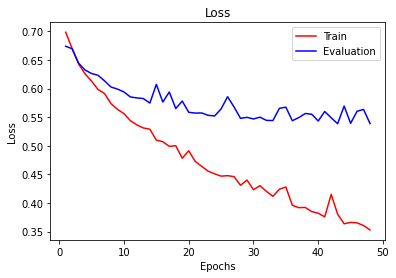

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Acc')

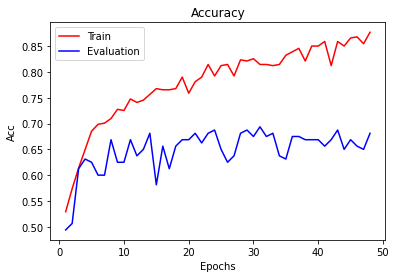

In [ ]:
# plot training curves

epochs = range(1, len(history['train_loss']) + 1)

plt.plot(epochs, history['train_loss'], 'r-', label='Train')
plt.plot(epochs, history['test_loss'], 'b-', label='Evaluation')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, history['train_acc'], 'r-', label='Train')
plt.plot(epochs, history['test_acc'], 'b-', label='Evaluation')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

### Using data augmentation 

In [ ]:
# add augmentation
# train the model with augmented data


data_augmentation = transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                        transforms.RandomRotation(5),
                                        #transforms.RandomHorizontalFlip(p=0.5),
                                         transforms.RandomVerticalFlip(p=0.5),
                                        transforms.Resize((250, 250)),  
                                        transforms.ToTensor()
                                        ])
train_data = CT_Dataset(images_train, y_train, img_transforms=data_augmentation)
test_data = CT_Dataset(images_val, y_val, img_transforms=data_augmentation) 

In [ ]:
# Train the CNN model
cnn_model = Convnet()
history = train_model(cnn_model, train_data, test_data, device, batch_size=32, epochs=100, lr=0.00001)

Training Starts 
Epoch:1 / 100, train loss:0.6866 train_acc:0.5179           valid loss:0.6573 valid acc:0.5813
Epoch:2 / 100, train loss:0.6378 train_acc:0.6540           valid loss:0.6285 valid acc:0.6125
Validation loss decreased (inf --> 0.628542).  Saving model ...
Epoch:3 / 100, train loss:0.6299 train_acc:0.6362           valid loss:0.6201 valid acc:0.6438
Validation loss decreased (0.628542 --> 0.620146).  Saving model ...
Epoch:4 / 100, train loss:0.6243 train_acc:0.6384           valid loss:0.6309 valid acc:0.5813
EarlyStopping counter: 1 out of 5
Epoch:5 / 100, train loss:0.6078 train_acc:0.6964           valid loss:0.6020 valid acc:0.6375
Validation loss decreased (0.620146 --> 0.602007).  Saving model ...
Epoch:6 / 100, train loss:0.5968 train_acc:0.6808           valid loss:0.6057 valid acc:0.6375
EarlyStopping counter: 1 out of 5
Epoch:7 / 100, train loss:0.5768 train_acc:0.7054           valid loss:0.6007 valid acc:0.6375
Validation loss decreased (0.602007 --> 0.600669

Text(0.5, 1.0, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

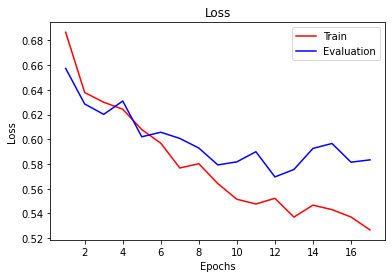

Text(0.5, 1.0, 'Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Acc')

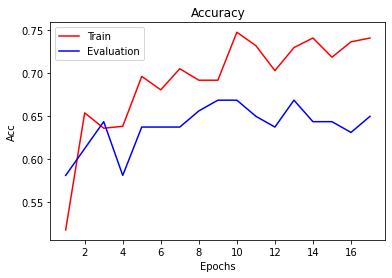

In [ ]:
# plot training curves

epochs = range(1, len(history['train_loss']) + 1)

plt.plot(epochs, history['train_loss'], 'r-', label='Train')
plt.plot(epochs, history['test_loss'], 'b-', label='Evaluation')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, history['train_acc'], 'r-', label='Train')
plt.plot(epochs, history['test_acc'], 'b-', label='Evaluation')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()